In [354]:
from typing import List
import re
from math import log
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [355]:
def matching_graph(d: int, probabilities: List[float]) -> nx.Graph:
    """Get the matching graph for the repetition code.
    
    Arguments:
    d - Distance of the code. Should be odd.
    probabilities - A list of bit-flip probablities.
    
    Returns:
    M - The matching graph for this code and error model."""

    assert d >= 3, f"Distance must be >= 3, but got {d}."
    assert d % 2 != 0, f"Distance d must be odd, but got {d}."

    matching_graph = nx.Graph()
    # First add the "extra nodes" for the leftmost and rightmost qubits.
    matching_graph.add_node("r1")
    matching_graph.add_node("r2")
    # Then add the regular syndromes
    for i in range(d - 1):
        matching_graph.add_node(f"s{i}")
    # Add an edge of weight w = log((1-p_i)/p_i) for each qubit.
    for i in range(d):
        w = log((1. - probabilities[i]) / probabilities[i])
        if i == 0:
            matching_graph.add_edge("r1", "s0", weight=w, label="q0")
        elif i == d - 1:
            matching_graph.add_edge("r2", f"s{i-1}", weight=w, label=f"q{i}")
        else:
            matching_graph.add_edge(f"s{i-1}", f"s{i}", weight=w, label=f"q{i}")
    return matching_graph

In [356]:
def error_to_syndrome(err: np.ndarray) -> np.ndarray:
    """Convert a list of bit-flips into a the repetition code syndrome."""

    d = err.size
    check = np.zeros((d-1, d), dtype=bool)
    for i in range(d - 1):
        check[i, i] = True
        check[i, i + 1] = True
    return ((check.astype(int) @ err.astype(int)) % 2).astype(bool)

In [357]:
def syndrome_graph(matching: nx.Graph, syndrome: np.ndarray) -> nx.Graph:
    """Gets the syndrome graph for a binary syndrome vector given the
    matching graph."""

    d = len(matching.nodes()) - 1
    assert syndrome.size == d - 1

    syndrome_nodes: List[str] = []
    # Build a graph with a node for each 1 in the syndrome.
    # The weight between two nodes will be the distance on the matching graph.
    syndrome_gr = nx.Graph()
    for i, b in enumerate(syndrome):
        if b:
            syndrome_gr.add_node(f"s{i}")
    # If there is an odd number of ones in the syndrome,
    # we need to add in one of our "dummy" nodes because there is a flip
    # on the leftmost or rightmost bit.
    # Find the lowest index i such that syndrome[i] = 1.
    # If i <= d / 2, then add the left dummy.
    # If i >= d / 2, then add the right dummy.
    for first_i, b in enumerate(syndrome):
        if b:
            break
    if first_i <= (d - 1) // 2:
        syndrome_gr.add_node("r1")
    else:
        syndrome_gr.add_node("r2")
    assert set(syndrome_gr.nodes()).issubset(matching.nodes())
    for sn1 in syndrome_gr.nodes():
        for sn2 in syndrome_gr.nodes():
            if sn1 != sn2:
                length = nx.shortest_path_length(matching, sn1, sn2, weight='weight')
                syndrome_gr.add_edge(sn1, sn2, weight=length)
    return syndrome_gr

In [358]:
def repetition_tanner_graph(d: int) -> nx.Graph:
    """Get the Tanner graph for a repetition code."""

    assert d % 2 != 0
    assert d >= 3

    tanner_graph = nx.Graph()
    for i in range(d):
        tanner_graph.add_node(f"q{i}")
        if i == 0:
            tanner_graph.add_node(f"r1")
            tanner_graph.add_node(f"s0")
            tanner_graph.add_edge("q0", "r1")
            tanner_graph.add_edge("q0", "s0")
        elif i == d - 1:
            tanner_graph.add_node("r2")
            tanner_graph.add_edge(f"q{i}", "r2")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
        else:
            tanner_graph.add_node(f"s{i}")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
            tanner_graph.add_edge(f"q{i}", f"s{i}")
    return tanner_graph

In [359]:
def matching_to_correction(matching, matching_gr, tanner_graph) -> np.ndarray:
    """Convert the minimum-weight matching to a binary correction."""

    def qubit_for_syndrome_pair(s1, s2):
        s1_neighbors = set(tanner_graph.neighbors(s1))
        s2_neighbors = set(tanner_graph.neighbors(s2))
        shared_nodes = s1_neighbors & s2_neighbors
        assert len(shared_nodes) == 1, f"{s1_neighbors} {s2_neighbors}"
        q_name = list(shared_nodes)[0]
        idx = int(re.search(r'\d+', q_name).group()) 
        return idx

    # Count qubits in the Tanner graph.
    nq = 0
    for node in tanner_graph.nodes():
        if 'q' in node:
            nq += 1

    correction = [False] * nq
    for n1, n2 in matching:
        # Get a path from n1 to n2 on the matching graph.
        # Each edge on the path will give us a qubit.
        path = nx.shortest_path(matching_gr, n1, n2)
        for i in range(len(path) - 1):
            s1 = path[i]
            s2 = path[i+1]
            idx = qubit_for_syndrome_pair(s1, s2)
            correction[idx] = True
    return np.array(correction)

In [360]:
d = 5
probs = [0.1] * d
err = np.array([False, False, False, True, True])
syndrome = error_to_syndrome(err)
print(f"syndrome = {syndrome}")

tanner_graph = repetition_tanner_graph(d)
matching_gr = matching_graph(d, probs)
syndrome_gr = syndrome_graph(matching_gr, syndrome)
print(f"syndrome graph nodes: {syndrome_gr.nodes()}")
matching = nx.min_weight_matching(syndrome_gr)
print("matching =", matching)
correction = matching_to_correction(matching, matching_gr, tanner_graph)
print(f"correction = {correction}")
print(correction ^ err)

syndrome = [False False  True False]
syndrome graph nodes: ['s2', 'r1']
matching = {('r1', 's2')}
correction = [ True  True  True False False]
[ True  True  True  True  True]


{'q0': Text(-0.7074018578993948, -0.6508460174221591, 'q0'),
 'r1': Text(-1.0, -0.5761563466915962, 'r1'),
 's0': Text(-0.3505450915219286, -0.6362285458766311, 's0'),
 'q1': Text(0.015655201312833215, -0.5277092754454897, 'q1'),
 's1': Text(0.3436486276745569, -0.3171751149002874, 's1'),
 'q2': Text(0.5796174783260569, -0.0159983334970491, 'q2'),
 's2': Text(0.6587626578811905, 0.3325250032753056, 's2'),
 'q3': Text(0.5285682672728311, 0.6376934637316084, 'q3'),
 's3': Text(0.2314675903012804, 0.7598061598842275, 's3'),
 'q4': Text(-0.0701320077225802, 0.6343801036601961, 'q4'),
 'r2': Text(-0.22964086562484431, 0.3597089032818747, 'r2')}

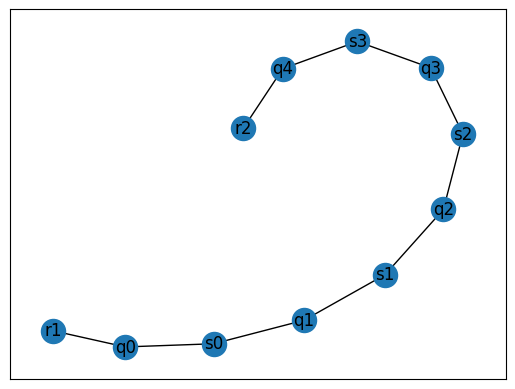

In [361]:
plt.figure()
pos = nx.spring_layout(tanner_graph)
nx.draw_networkx_nodes(tanner_graph, pos)
nx.draw_networkx_edges(tanner_graph, pos)
nx.draw_networkx_labels(tanner_graph, pos)

{'r1': Text(1.0, 0.1873062121460888, 'r1'),
 'r2': Text(-0.9973230199643774, -0.20489834642856072, 'r2'),
 's0': Text(0.6377668137791294, 0.1256510114386205, 's0'),
 's1': Text(0.21446458447347616, 0.05101347640248769, 's1'),
 's2': Text(-0.21669338004520705, -0.03430858645525521, 's2'),
 's3': Text(-0.6382149982430212, -0.12476376710338144, 's3')}

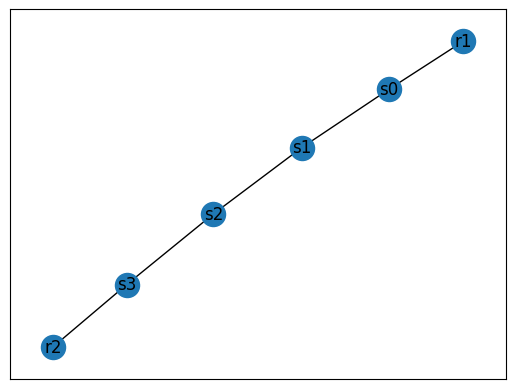

In [362]:
plt.figure()
pos = nx.spring_layout(matching_gr)
nx.draw_networkx_nodes(matching_gr, pos)
nx.draw_networkx_edges(matching_gr, pos)
nx.draw_networkx_labels(matching_gr, pos)

{'s2': Text(-0.9130148931643965, 0.9999999999999999, 's2'),
 'r1': Text(0.9130148931643965, -1.0, 'r1')}

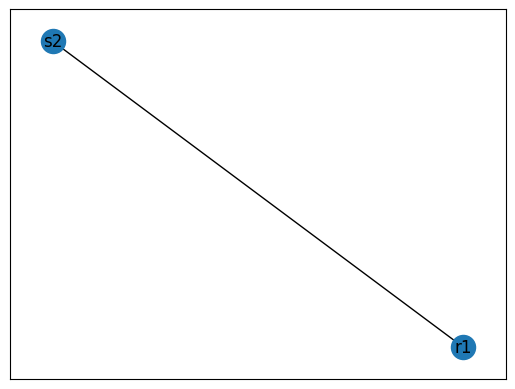

In [363]:
plt.figure()
pos = nx.spring_layout(syndrome_gr)
nx.draw_networkx_nodes(syndrome_gr, pos)
nx.draw_networkx_edges(syndrome_gr, pos)
nx.draw_networkx_labels(syndrome_gr, pos)